In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import h5py
from sklearn.linear_model import Ridge, Lasso, LassoCV, LassoLarsCV, LinearRegression, BayesianRidge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import time
# import statsmodels.api as sm
# from patsy import dmatrix

# Here we are importing the h5 file and create a dataframe.

In [2]:
file = h5py.File('Data_Fuchs_v_2.7_Wright_Pat_Narrow_Range_energy_limit_0.01_deviation_0.0_lambda_um_0.8_points_100000_seed_3.h5','r')
file_dict = dict()
for i in file.keys():
    file_dict[i] = file[i][:]
file.close()
physics = pd.DataFrame(file_dict)

# Here we specify the input and output variables

In [3]:
outputs = ['Max_Proton_Energy_(MeV)', 'Total_Proton_Energy_(MeV)', 'Avg_Proton_Energy_(MeV)']

In [4]:
# this is to avoid copying a pasting
inputs = []
for i in physics.columns:
    if i in outputs:
        continue
    else:
        inputs.append(i)
inputs

['Intensity_(W_cm2)',
 'Pulse_Duration_(fs)',
 'Spot_Size_(FWHM um)',
 'Target_Thickness (um)']

# Scatter plots of all the input variables with Max_Proton_Energy(MeV)

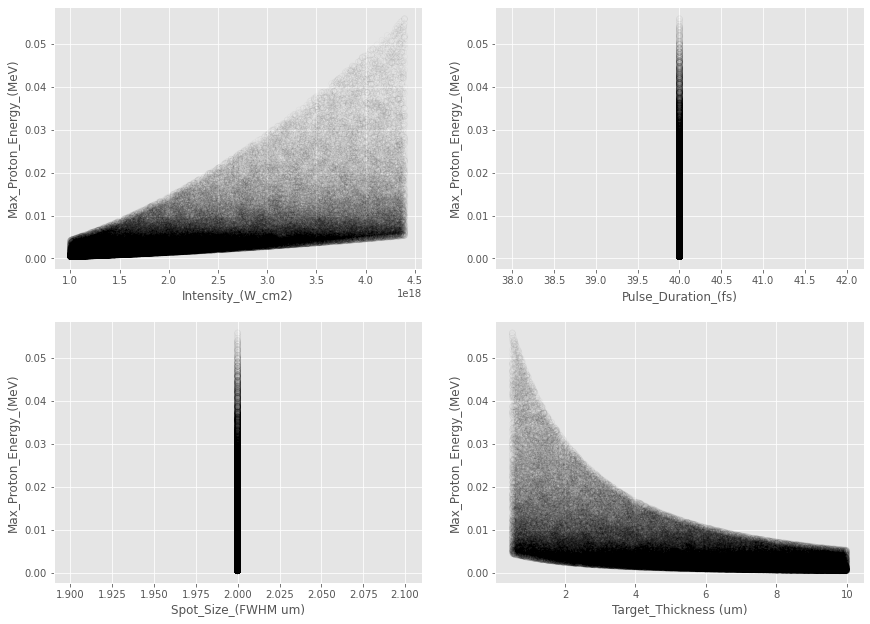

In [5]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].scatter(physics[inputs[0]],physics[outputs[0]], facecolor='None', edgecolor='k', alpha=0.035)
axs[0, 0].set(xlabel=f'{inputs[0]}', ylabel=f'{outputs[0]}')

axs[0, 1].scatter(physics[inputs[1]], physics[outputs[0]], facecolor='None', edgecolor='k', alpha=0.035)
axs[0, 1].set(xlabel=f'{inputs[1]}', ylabel=f'{outputs[0]}')

axs[1, 0].scatter(physics[inputs[2]], physics[outputs[0]], facecolor='None', edgecolor='k', alpha=0.035)
axs[1, 0].set(xlabel=f'{inputs[2]}', ylabel=f'{outputs[0]}')

axs[1, 1].scatter(physics[inputs[3]], physics[outputs[0]], facecolor='None', edgecolor='k', alpha=0.035)
axs[1, 1].set(xlabel=f'{inputs[3]}', ylabel=f'{outputs[0]}')

plt.subplots_adjust(bottom=1, right=2, top=3)

##### For now, we will work with a dataframe that only has Max Proton Energy as the output variable and name it df1.

In [6]:
df1 = physics.copy()
df1 = df1.drop(columns=outputs[1:])
df1.columns

Index(['Intensity_(W_cm2)', 'Max_Proton_Energy_(MeV)', 'Pulse_Duration_(fs)',
       'Spot_Size_(FWHM um)', 'Target_Thickness (um)'],
      dtype='object')

##### The train and split sets will also be created here for df1.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df1[inputs], df1[outputs[0]], test_size=0.33, random_state=0)

# Now we will create a model with max proton energy as the output. The inputs will be target thickness and intensity.

##### The colors in the following scatter plot are only to give the plot a 3d feel. The colors are not meant to indicate the value of a fourth variable.

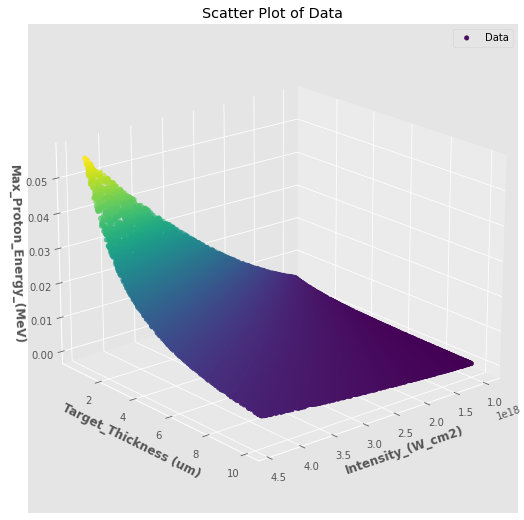

In [8]:
fig1 = plt.figure(figsize=(9, 9))
ax = fig1.add_subplot(projection='3d')
ax.scatter(X_train[inputs[0]],
           X_train[inputs[3]],
           y_train,
           c = y_train / (np.log(X_train[inputs[0]] + X_train[inputs[3]]))**9,
           label = "Data")
ax.set_title('Scatter Plot of Data')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'{outputs[0]}', fontweight ='bold')
ax.view_init(20, 50)
plt.legend(loc="upper right")
plt.show()

##### This creates a model with the out variable max proton energy against both input variables target thickness and intensity.

In [9]:
start_time = time.process_time()

In [10]:
spline_mpe_int_tt_var = make_pipeline(SplineTransformer(n_knots=10, degree=3), Ridge(alpha=.001))

In [11]:
spline_mpe_int_tt_var.fit(X_train[[inputs[0], inputs[3]]], y_train)

Pipeline(steps=[('splinetransformer', SplineTransformer(n_knots=10)),
                ('ridge', Ridge(alpha=0.001))])

In [12]:
print(f'The MSE of the testing set is {mean_squared_error(y_test,spline_mpe_int_tt_var.predict(X_test[[inputs[0], inputs[3]]]))}.')

The MSE of the testing set is 1.013226536042261e-05.


In [13]:
end_time = time.process_time()
print(f'The CPU time for this model to run is {end_time - start_time} seconds.')
del start_time
del end_time

The CPU time for this model to run is 0.2438090000000006 seconds.


In [14]:
y_mpe_int_tt_var_model_var = spline_mpe_int_tt_var.predict(X_train[[inputs[0], inputs[3]]])

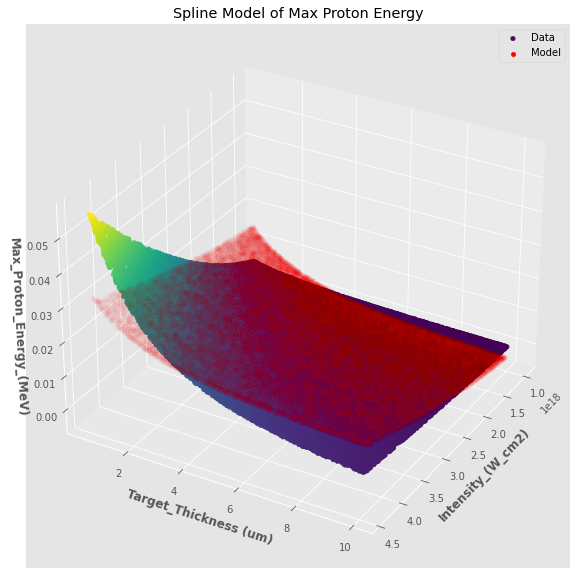

In [15]:
fig2 = plt.figure(figsize=(10, 10))
ax = fig2.add_subplot(projection='3d')
ax.scatter(X_train[inputs[0]],
           X_train[inputs[3]],
           y_train,
           c = y_train/ (np.log(X_train[inputs[0]] + X_train[inputs[3]]))**9,
           label= 'Data')
ax.scatter(X_train[inputs[0]],
           X_train[inputs[3]],
           y_mpe_int_tt_var_model_var,
           c = 'red',
           alpha= .015,
           label= 'Model')
ax.set_title('Spline Model of Max Proton Energy')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'{outputs[0]}', fontweight ='bold')
ax.view_init(30, 30)
plt.legend(loc="upper right")
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[1].set_alpha(1)
plt.show()

##### A dataframe will be created to contain the relative errors for the y test set not in percentage, and it will also the X test set

In [16]:
error_series = np.abs((y_test - spline_mpe_int_tt_var.predict(X_test[[inputs[0], inputs[3]]])) / y_test)
error_3d = X_test[[inputs[0], inputs[3]]].copy()
error_3d['Relative Error'] = error_series

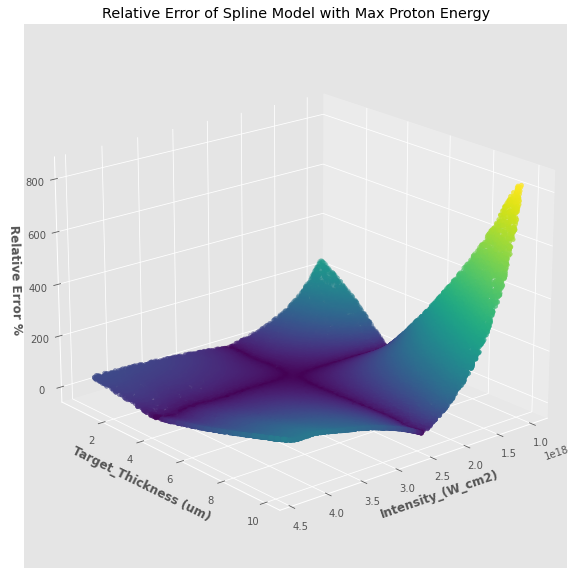

In [17]:
fig5 = plt.figure(figsize=(10, 10))
ax = fig5.add_subplot(projection='3d')
ax.scatter(X_test[inputs[0]],
           X_test[inputs[3]],
           error_3d['Relative Error'] * 100,
           c = np.sqrt(error_3d['Relative Error']))
ax.set_title('Relative Error of Spline Model with Max Proton Energy')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'Relative Error %', fontweight ='bold')
ax.view_init(20, 50)
plt.show()

##### This time a model will be created with log(max proton energy) instead of just max proton energy, still with the same input variables.

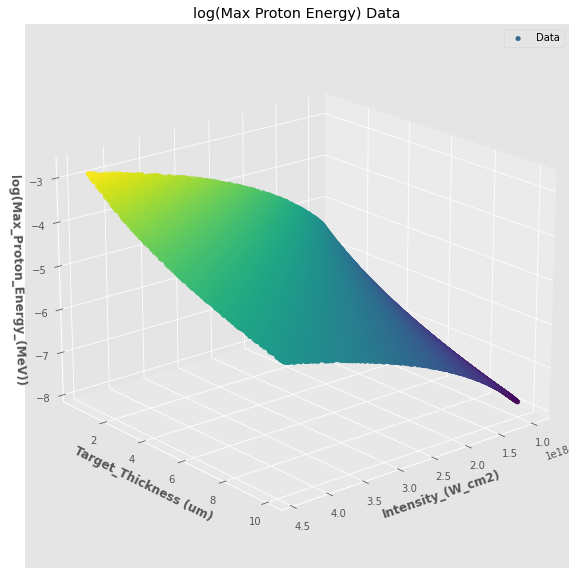

In [18]:
fig3 = plt.figure(figsize=(10, 10))
ax = fig3.add_subplot(projection='3d')
ax.scatter(X_train[inputs[0]],
           X_train[inputs[3]],
           np.log(y_train),
           c=np.log(y_train),
           label='Data')
ax.set_title('log(Max Proton Energy) Data')
ax.set_xlabel(f'{inputs[0]}', fontweight='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight='bold')
ax.set_zlabel(f'log({outputs[0]})', fontweight='bold')
ax.view_init(20, 50)
plt.legend()
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_alpha(1)
plt.show()

##### Creating the log spline model.

In [19]:
start_time = time.process_time()

In [20]:
spline_mpe_int_tt_var_log = make_pipeline(SplineTransformer(n_knots=8, degree=3), Ridge(alpha=.001))

In [21]:
spline_mpe_int_tt_var_log.fit(X_train[[inputs[0], inputs[3]]], np.log(y_train))

Pipeline(steps=[('splinetransformer', SplineTransformer(n_knots=8)),
                ('ridge', Ridge(alpha=0.001))])

In [22]:
y_mpe_int_tt_var_model_var_log = spline_mpe_int_tt_var_log.predict(X_train[[inputs[0], inputs[3]]])

##### CPU time to run, train, and predict data

In [23]:
end_time = time.process_time()
print(f'The CPU time for this model to run is {end_time - start_time} seconds.')
del start_time
del end_time

The CPU time for this model to run is 0.262910999999999 seconds.


##### Mean squared error of y testing set of the log spline model using the X testing set

In [24]:
mean_squared_error(np.log(y_test),
                   spline_mpe_int_tt_var_log.predict(X_test[[inputs[0], inputs[3]]])
                   )

1.2573307698913297e-06

##### Scatter plot of the predictions of the model compared to the data

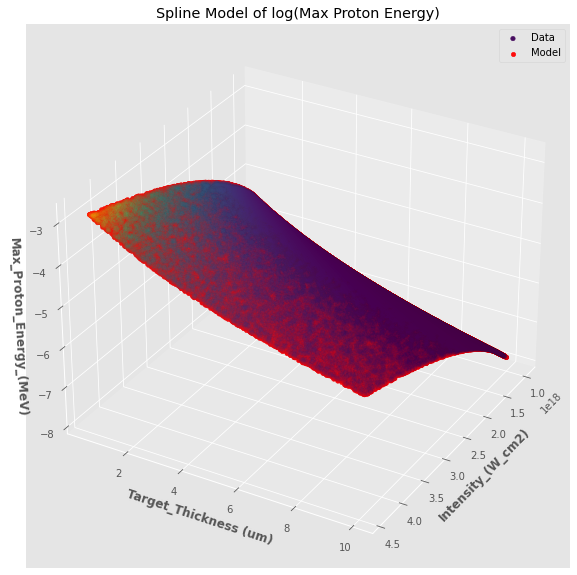

In [25]:
fig4 = plt.figure(figsize=(10, 10))
ax = fig4.add_subplot(projection='3d')
ax.scatter(X_train[inputs[0]],
           X_train[inputs[3]],
           np.log(y_train),
           c = y_train/ (np.log(X_train[inputs[0]] + X_train[inputs[3]]))**9,
           alpha= .05,
           label= 'Data')
ax.scatter(X_train[inputs[0]],
           X_train[inputs[3]],
           y_mpe_int_tt_var_model_var_log,
           c = 'red',
           alpha= .95,
           label= 'Model')
ax.set_title('Spline Model of log(Max Proton Energy)')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'{outputs[0]}', fontweight ='bold')
ax.view_init(30, 30)
plt.legend()
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_alpha(1)
plt.show()

##### An error dataframe will be created for the log transformed data model for the testing sets. This dataframe will also contain the predicted values of the log model, and it will contain the predicted values of the model converted back into its original non log format.

In [26]:
error_series_log = np.abs((np.log(y_test) - spline_mpe_int_tt_var_log.predict(X_test[[inputs[0], inputs[3]]])) / np.log(y_test))
error_3d_log = X_test[[inputs[0], inputs[3]]].copy()
error_3d_log['Relative Error'] = error_series_log
error_3d_log['prediction in log'] = spline_mpe_int_tt_var_log.predict(X_test[[inputs[0], inputs[3]]])
error_3d_log['converted prediction'] = np.exp(spline_mpe_int_tt_var_log.predict(X_test[[inputs[0], inputs[3]]]))
error_3d_log['Relative Error of Original y_test'] = np.abs((error_3d_log['converted prediction'] - y_test) / y_test)

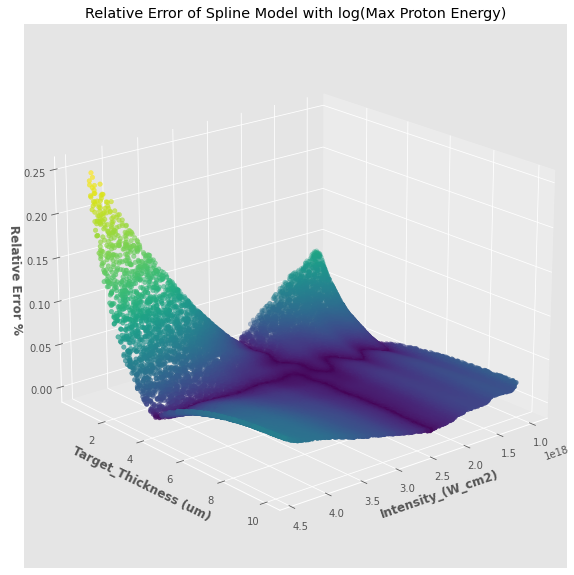

In [27]:
fig6 = plt.figure(figsize=(10, 10))
ax = fig6.add_subplot(projection='3d')
ax.scatter(X_test[inputs[0]],
           X_test[inputs[3]],
           error_3d_log['Relative Error'] * 100,
           c = np.sqrt(error_3d_log['Relative Error']))
ax.set_title('Relative Error of Spline Model with log(Max Proton Energy)')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'Relative Error %', fontweight ='bold')
ax.view_init(20, 50)
plt.show()

##### Scatter plot of the log model converted back to original format

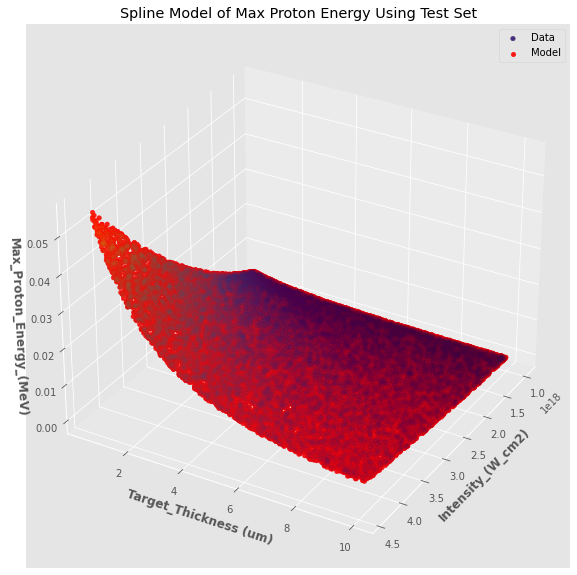

In [28]:
fig4_5 = plt.figure(figsize=(10, 10))
ax = fig4_5.add_subplot(projection='3d')
ax.scatter(X_test[inputs[0]],
           X_test[inputs[3]],
           y_test,
           c = y_test,
           alpha= .05,
           label= 'Data')
ax.scatter(X_test[inputs[0]],
           X_test[inputs[3]],
           error_3d_log['converted prediction'],
           c = 'red',
           alpha= .90,
           label= 'Model')
ax.set_title('Spline Model of Max Proton Energy Using Test Set')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'{outputs[0]}', fontweight ='bold')
ax.view_init(30, 30)
plt.legend()
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_alpha(1)
plt.show()

##### Scatter plot of the relative error of exp(log(max proton energy)) compared to y_test

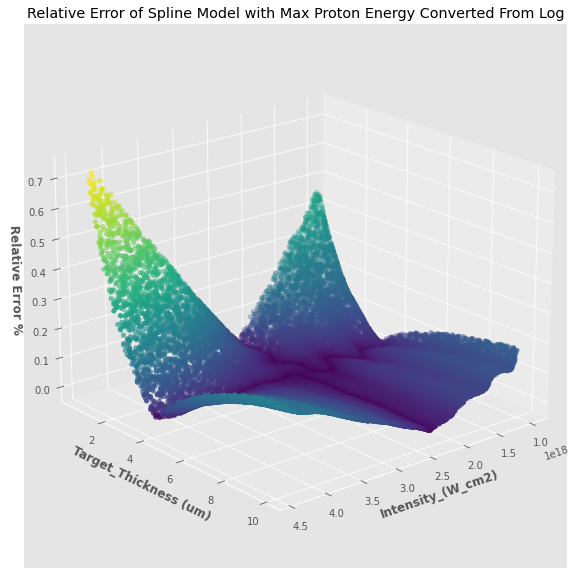

In [29]:
fig6_5 = plt.figure(figsize=(10, 10))
ax = fig6_5.add_subplot(projection='3d')
ax.scatter(X_test[inputs[0]],
           X_test[inputs[3]],
           error_3d_log['Relative Error of Original y_test'] * 100,
           c = np.sqrt(error_3d_log['Relative Error']))
ax.set_title('Relative Error of Spline Model with Max Proton Energy Converted From Log')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'Relative Error %', fontweight ='bold')
ax.view_init(20, 50)
plt.show()

In [30]:
mean_squared_error(y_test,
                   error_3d_log['converted prediction']
                   )

7.306763530604971e-10